# Problem definitions

In [37]:
from qiskit.quantum_info import SparsePauliOp

observable_1 = SparsePauliOp.from_list([("II", 2), ("XX", -2), ("YY", 3), ("ZZ", -3)])

# Custom VQE

We'll first explore how to construct a VQE instance manually to find the lowest eigenvalue for $\hat{O}_1$. This will incorporate a variety of techniques that we have covered throughout this course.

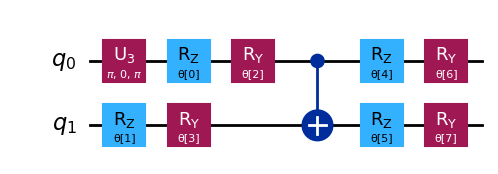

In [38]:
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs

    return cost

from qiskit.circuit.library import TwoLocal
from qiskit import QuantumCircuit
import numpy as np

reference_circuit = QuantumCircuit(2)
reference_circuit.x(0)

variational_form = TwoLocal(
    2,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1
)
raw_ansatz = reference_circuit.compose(variational_form)

raw_ansatz.decompose().draw("mpl")

In [39]:
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit.primitives import StatevectorSampler as Sampler
estimator = Estimator()
sampler = Sampler()

import numpy as np

x0 = np.ones(raw_ansatz.num_parameters)
print(x0)

[1. 1. 1. 1. 1. 1. 1. 1.]


In [40]:
# Scipy minimiser routine

from scipy.optimize import minimize
import time

start_time = time.time()

result = minimize(cost_func_vqe, x0, args=(raw_ansatz, observable_1, estimator), method="COBYLA", options={'maxiter': 1000, 'disp': True})

end_time = time.time()
execution_time = end_time - start_time


Because this toy problem uses only two qubits, we can check this by using Numpy's linear algebra eigensolver.

In [41]:
from numpy.linalg import eigvalsh

solution_eigenvalue = min(eigvalsh(observable_1.to_matrix()))

print(f"""Number of iterations: {result.nfev}""")
print(f"""Time (s): {execution_time}""")

print(
    f"Percent error: {abs((result.fun - solution_eigenvalue)/solution_eigenvalue):.2e}"
)

Number of iterations: 130
Time (s): 0.5296576023101807
Percent error: 3.52e-09


# Experimenting to improve speed and accuracy


### Add reference state

In the previous example we have not used any reference operator $U_R$. Now let us think about how the ideal eigenstate $\frac{1}{\sqrt{2}}(|00 \rangle + | 11 \rangle)$ can be obtained. Consider the following circuit.

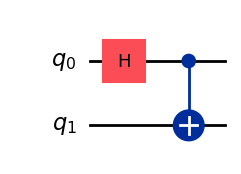

In [42]:
from qiskit import QuantumCircuit

ideal_qc = QuantumCircuit(2)
ideal_qc.h(0)
ideal_qc.cx(0, 1)

ideal_qc.draw("mpl")

In [43]:
# We can quickly check that this circuit gives us the desired state.

from qiskit.quantum_info import Statevector

Statevector(ideal_qc)

Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.70710678+0.j],
            dims=(2, 2))


Now that we have seen how a circuit preparing the solution state looks like, it seems reasonable to use a Hadamard gate as a reference circuit, so that the full ansatz becomes:

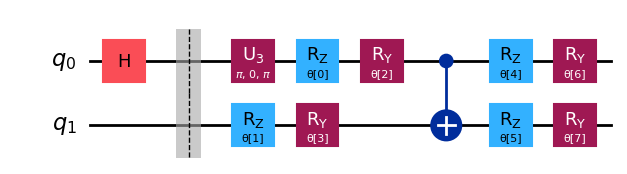

In [44]:
reference = QuantumCircuit(2)
reference.h(0)
# Include barrier to separate reference from variational form
reference.barrier()

ref_ansatz = raw_ansatz.decompose().compose(reference, front=True)

ref_ansatz.draw("mpl")

For this new circuit, the ideal solution could be reached with all the parameters set to 
0
0, so this confirms that the choice of reference circuit is reasonable.

Now let us compare the number of cost function evaluations, optimizer iterations and time taken with those of the previous attempt.

In [45]:
import time

start_time = time.time()

ref_result = minimize(cost_func_vqe, x0, args=(ref_ansatz, observable_1, estimator), method="COBYLA")

end_time = time.time()
execution_time = end_time - start_time

# Using our optimial parameters to calculate the minimum eigenvalue:

experimental_min_eigenvalue_ref = cost_func_vqe(result.x, raw_ansatz, observable_1, estimator)
print(experimental_min_eigenvalue_ref)

print("ADDED REFERENCE STATE:")
print(f"""Number of iterations: {result.nfev}""")
print(f"""Time (s): {execution_time}""")
print(
    f"Percent error: {abs((experimental_min_eigenvalue_ref - solution_eigenvalue)/solution_eigenvalue):.2e}"
)

-5.99999997890921
ADDED REFERENCE STATE:
Number of iterations: 130
Time (s): 0.6249988079071045
Percent error: 3.52e-09


### Change initial point

Now that we have seen the effect of adding the reference state, we will go into what happens when we choose different initial points $\vec{\theta_0}$. In particular we will use $\vec{\theta_0}$=(0,0,0,0,6,0,0,0) and $\vec{\theta_0}$=(6,6,6,6,6,6,6,6,6). Remember that, as discussed when the reference state was introduced, the ideal solution would be found when all the parameters are 0, so the first initial point should give fewer evaluations.

In [46]:
import time

start_time = time.time()

x0 = [0, 0, 0, 0, 6, 0, 0, 0]

x0_1_result = minimize(cost_func_vqe, x0, args=(raw_ansatz, observable_1, estimator), method="COBYLA")

end_time = time.time()
execution_time = end_time - start_time

print("INITIAL POINT 1:")
print(f"""Number of iterations: {x0_1_result.nfev}""")
print(f"""Time (s): {execution_time}""")

INITIAL POINT 1:
Number of iterations: 125
Time (s): 0.5380098819732666


In [47]:
import time

start_time = time.time()

x0 = 6 * np.ones(raw_ansatz.num_parameters)

x0_2_result = minimize(cost_func_vqe, x0, args=(raw_ansatz, observable_1, estimator), method="COBYLA")

end_time = time.time()
execution_time = end_time - start_time

print("INITIAL POINT 2:")
print(f"""Number of iterations: {x0_2_result.nfev}""")
print(f"""Time (s): {execution_time}""")

INITIAL POINT 2:
Number of iterations: 128
Time (s): 0.6015098094940186


### Experimenting with different optimizers

We can adjust the optimizer using SciPy minimize 's method argument, with more options found here. We originally used a constrained minimizer ( COBYLA ). In this example, we'll explore using an unconstrained minimizer ( BFGS ) instead

In [49]:
import time
start_time = time.time()

result = minimize(cost_func_vqe, x0, args=(raw_ansatz, observable_1, estimator), method="BFGS")

end_time = time.time()
execution_time = end_time - start_time

print("CHANGED TO BFGS OPTIMIZER:")
print(f"""Number of iterations: {result.nfev}""")
print(f"""Time (s): {execution_time}""")

CHANGED TO BFGS OPTIMIZER:
Number of iterations: 117
Time (s): 0.4986708164215088


# VQD Example

### Step 1: Map classical inputs to a quantum problem

Now instead of looking for only the lowest eigenvalue of our observables, we will look for 4.

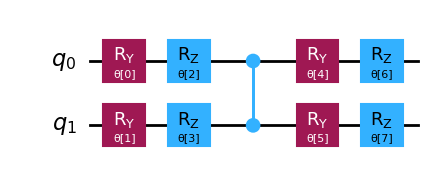

In [50]:
from qiskit.circuit.library import TwoLocal

ansatz = TwoLocal(2, rotation_blocks=["ry", "rz"], entanglement_blocks="cz", reps=1)

ansatz.decompose().draw("mpl")

In [51]:
from qiskit.quantum_info import SparsePauliOp

observable_2 = SparsePauliOp.from_list([("II", 2), ("XX", -3), ("YY", 2), ("ZZ", -4)])

We'll be using the following function to calculate the overlap penalty. Note that this is still part of mapping the problem to quantum circuits. However, as discussed in the previous lesson, this function calculates the overlap between a current variational circuit and the optimized circuit from a previous, lower-energy/cost state obtained. The new circuit being generated also has to be transpiled to run on real hardware. We have seen this function before, used on a simulator. Here, we must already consider the transpiling and related optimization for when we use a real backend, hence the lines around "if realbackend == 1". This is mixing a bit of step 2, but we will call out step 2 explicitly, later.

In [61]:
import numpy as np
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

def calculate_overlaps(ansatz, prev_circuits, parameters, sampler, realbackend,backend):

    def create_fidelity_circuit(circuit_1, circuit_2):
        if len(circuit_1.clbits) > 0:
            circuit_1.remove_final_measurements()
        if len(circuit_2.clbits) > 0:
            circuit_2.remove_final_measurements()

        circuit = circuit_1.compose(circuit_2.inverse())
        circuit.measure_all()
        return circuit
    overlaps = []

    for prev_circuit in prev_circuits:
        fidelity_circuit = create_fidelity_circuit(ansatz, prev_circuit)
        if realbackend == 1:
            pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
            fidelity_circuit = pm.run(fidelity_circuit)
        sampler_job = sampler.run([(fidelity_circuit, parameters)])
        meas_data = sampler_job.result()[0].data.meas
        
        counts_0 = meas_data.get_int_counts().get(0, 0)
        shots = meas_data.num_shots
        overlap = counts_0/shots
        overlaps.append(overlap)
    
    return np.array(overlaps)

def cost_func_vqd(parameters, ansatz, prev_states, step, betas, estimator, sampler, hamiltonian, realbackend, backend):

    estimator_job = estimator.run([(ansatz, hamiltonian, [parameters])])

    total_cost = 0

    if step > 1:
        overlaps = calculate_overlaps(ansatz, prev_states, parameters, sampler, realbackend, backend)
        total_cost = np.sum([np.real(betas[state] * overlap) for state, overlap in enumerate(overlaps)])

    estimator_result = estimator_job.result()[0]

    value = estimator_result.data.evs[0] + total_cost

    return value

# Once again, we will use simulators for debugging, and then move on to real hardware.

from qiskit.primitives import StatevectorSampler
from qiskit.primitives import StatevectorEstimator

sampler = StatevectorSampler(default_shots=4092)
estimator = StatevectorEstimator()

# Here we introduce the number of states we wish to calculate, the penalties, and a set of initial parameters, x0.

from qiskit.quantum_info import SparsePauliOp
import numpy as np

k = 4
betas = [50, 60, 40]
x0 = np.ones(8)

We will now test the algorithm using simulators:



In [62]:
from scipy.optimize import minimize

prev_states = []
prev_opt_parameters = []
eigenvalues = []

realbackend = 0

for step in range(1, k + 1):
    
    if step > 1:
        prev_states.append(ansatz.assign_parameters(prev_opt_parameters))
    
    result = minimize(cost_func_vqd, x0, args=(ansatz, prev_states, step, betas, estimator, sampler, observable_2, realbackend, None), method="COBYLA", options={'maxiter': 200, 'tol':0.000001})
    print(result)

    prev_opt_parameters = result.x
    eigenvalues.append(result.fun)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -6.9999999999970655
       x: [ 1.571e+00  1.571e+00  1.964e+00  2.148e+00  1.029e+00
            1.237e+00  1.703e+00  2.799e+00]
    nfev: 196
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 3.693758092963521
       x: [ 1.094e+00  9.148e-01  1.133e+00  1.116e+00  1.231e+00
            1.326e+00  8.253e-01  1.075e+00]
    nfev: 116
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 5.7224762472344155
       x: [ 1.866e+00  2.470e+00  2.591e+00  1.035e+00  1.434e+00
            2.644e+00  8.217e-01  5.998e-01]
    nfev: 121
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 6.422077429605074
       x: [ 2.329e+00  2.594e+00  9.102e-01  1.872e+00  2.477e+00
            5.191e-01 -1.559e-01  1.411e+00]
    nfev: 137
   maxcv: 0.0


In [66]:
eigenvalues

[-6.9999999999970655, 3.693758092963521, 5.7224762472344155, 6.422077429605074]

In [65]:
# These results are fairly close to the expected ones except for approximation error and global phase. We could adjust the tolerance on 
# the classical optimizer and/or the penalties for statevector overlap to obtain more precise values.

solution_eigenvalues = [-7, 3, 5, 7]

for index, experimental_eigenvalue in enumerate(eigenvalues):
    solution_eigenvalue = solution_eigenvalues[index]
    
    print(
        f"Percent error: {abs((experimental_eigenvalue - solution_eigenvalue)/solution_eigenvalue):.2e}"
    )

Percent error: 4.19e-13
Percent error: 2.31e-01
Percent error: 1.44e-01
Percent error: 8.26e-02


### Change betas

As mentioned in the previous lesson, the values of β should be bigger than the difference between eigenvalues. 
Let us see what happens when they do not satisfy that condition with observable_2

In [70]:
from qiskit.quantum_info import SparsePauliOp

k = 4
betas = np.ones(3)
x0 = np.zeros(8)

from scipy.optimize import minimize

prev_states = []
prev_opt_parameters = []
eigenvalues = []

realbackend = 0

for step in range(1, k + 1):
    
    if step > 1:
        prev_states.append(ansatz.assign_parameters(prev_opt_parameters))
    
    result = minimize(cost_func_vqd, x0, args=(ansatz, prev_states, step, betas, estimator, sampler, observable_2, realbackend, None), method="COBYLA", options = {'tol' : 0.01, 'maxiter': 200})
    print(result)

    prev_opt_parameters = result.x
    eigenvalues.append(result.fun)

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -2.8660482697012135
       x: [ 6.741e-01 -5.950e-01  1.608e-02  2.130e-02 -3.382e-01
            3.065e-01 -5.579e-01 -2.512e-01]
    nfev: 200
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.0601817806105895
       x: [-1.549e-02 -1.257e-02 -1.194e-01 -5.903e-03  1.445e-02
            5.571e-02  1.558e-02  6.234e-03]
    nfev: 45
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.0596599153508135
       x: [-3.609e-03  2.357e-03  1.642e-03  9.990e-01  3.598e-04
            6.753e-03 -4.438e-03 -3.507e-03]
    nfev: 39
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 0.9422722146972076
       x: [ 6.854e-03  2.122e-03  2.080e-03  1.004e+00  2.426e-03
           -6.455e-05 -4.629e-03  1.971e-03]
    nfev: 38
   maxcv: 0.0


In [71]:
solution_eigenvalues = [-7, 3, 5, 7]

for index, experimental_eigenvalue in enumerate(eigenvalues):
    solution_eigenvalue = solution_eigenvalues[index]
    
    print(
        f"Percent error: {abs((experimental_eigenvalue - solution_eigenvalue)/solution_eigenvalue):.2e}"
    )

Percent error: 5.91e-01
Percent error: 1.35e+00
Percent error: 1.01e+00
Percent error: 8.65e-01


### Step 2: Optimize problem for quantum execution



In [73]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import Session, EstimatorOptions
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.least_busy(operational=True, simulator=False)
print(backend)

<IBMBackend('ibm_sherbrooke')>


In [74]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_ansatz = pm.run(ansatz)
isa_observable = observable_2.apply_layout(layout = isa_ansatz.layout)

### Step 3: Execute using Qiskit primitives (CANNOT RUN AS > 10MIN !)

In [ ]:
#Estimated compute resource usage: 25 minutes. Benchmarked at 24 min, 30 s on ibm_nazca on 5-30-24

k = 2
betas = [30, 50, 80]
x0 = np.zeros(8)

real_prev_states = []
real_prev_opt_parameters = []
real_eigenvalues = []

realbackend = 1

estimator_options = EstimatorOptions(
    resilience_level=1,
    default_shots = 10_000
)

with Session(backend=backend) as session:

    estimator = Estimator(mode=session, options = estimator_options)
    sampler = Sampler(mode = session)
    
    for step in range(1, k + 1):
    
        if step > 1:
            real_prev_states.append(isa_ansatz.assign_parameters(prev_opt_parameters))
    
        result = minimize(cost_func_vqd, x0, args=(isa_ansatz, real_prev_states, step, betas, estimator, sampler, isa_observable, realbackend, backend), method="COBYLA", options = {'maxiter':200})
        print(result)

        real_prev_opt_parameters = result.x
        real_eigenvalues.append(result.fun)

session.close()
print(real_eigenvalues)

### Step 4: Post-process, return result in classical format

Our output is structurally similar to what has been dicussed in previous lessons and examples. But there is something problematic in the results above, from which we can derive a cautionary message for the context of excited states. To limit computing time used on this learning example, we set a maximum number of iterations for classical optimizer that was potentially too low: 200 iterations. A previous calculation above, on a simulator, failed to converge in 200 iterations. Here, ours did converge... but to what tolerance? We have not specified a tolerance for COBYLA to consider itself "converged". A glance at the function value and comparison with previous runs tells us that COBYLA was not close to converging to the precision we require.

There is another issue: the energy of the first excited state appears to be lower than the energy of the ground state! See if you can explain how this could happen. Hint: it is related to the convergence point we just addressed. This behavior is explained in detail below after VQD is applied to the H2 molecule.

# Quantum Chemistry

Our objective is to minimize the expectation value of the observable representing energy (Hamiltonian).

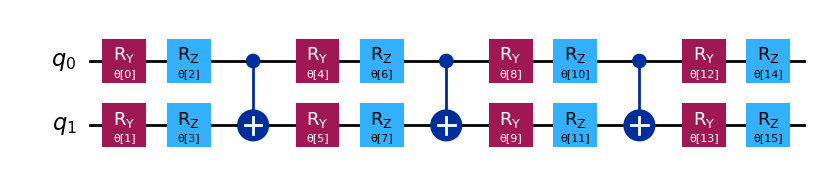

In [76]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import EfficientSU2

H2_op = SparsePauliOp.from_list(
    [
        ("II", -1.052373245772859),
        ("IZ", 0.39793742484318045),
        ("ZI", -0.39793742484318045),
        ("ZZ", -0.01128010425623538),
        ("XX", 0.18093119978423156),
    ]
)

chem_ansatz = EfficientSU2(H2_op.num_qubits)

chem_ansatz.decompose().draw("mpl")

In [81]:
from qiskit.circuit.library import TwoLocal
from qiskit import QuantumCircuit


def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs
#    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

import numpy as np

x0 = np.ones(chem_ansatz.num_parameters)

from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit.primitives import StatevectorSampler as Sampler
estimator = Estimator()
sampler = Sampler()

# SciPy minimizer routine
from scipy.optimize import minimize
import time

start_time = time.time()

result = minimize(cost_func_vqe, x0, args=(chem_ansatz, H2_op, estimator), method="COBYLA")

end_time = time.time()
execution_time = end_time - start_time

result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.8572750288171584
       x: [ 8.052e-01  1.459e+00 ...  1.004e+00  1.565e+00]
    nfev: 277
   maxcv: 0.0

### Excited states

In [87]:
from qiskit.quantum_info import SparsePauliOp
import numpy as np

# We can also leverage VQD to solve for k=2 total states (the ground state and the first excited state).

k = 2
betas = [33, 33]
#x0 = np.zeros(ansatz.num_parameters)
x0=[ 1.164e+00, -2.438e-01,  9.358e-04,  6.745e-02,  1.990e+00,   9.810e-02,  6.154e-01,  5.454e-01]



# We'll add our overlap calculation:

from scipy.optimize import minimize

prev_states = []
prev_opt_parameters = []
eigenvalues = []

realbackend = 0

for step in range(1, k + 1):
    
    if step > 1:
        prev_states.append(ansatz.assign_parameters(prev_opt_parameters))
    
    result = minimize(cost_func_vqd, x0, args=(ansatz, prev_states, step, betas, estimator, sampler, H2_op, realbackend, None), method="COBYLA", options = {'tol': 0.001, 'maxiter': 2000})
    print(result)

    prev_opt_parameters = result.x
    eigenvalues.append(result.fun)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.8572667787163357
       x: [ 1.164e+00 -2.434e-01  1.760e-03  6.709e-02  1.991e+00
            9.787e-02  6.154e-01  5.456e-01]
    nfev: 50
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.0615750915121227
       x: [ 3.029e+00  1.942e+00  1.104e+00 -1.230e-01  3.130e+00
            1.700e+00  1.144e+00  8.453e-01]
    nfev: 132
   maxcv: 0.0


In [88]:
eigenvalues

[-1.8572667787163357, -1.0615750915121227]

### Real hardware and a final cautionary message

In [89]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import Session, EstimatorOptions
from qiskit_ibm_runtime import QiskitRuntimeService


service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.least_busy(operational=True, simulator=False)

In [90]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_ansatz = pm.run(ansatz)
isa_observable = H2_op.apply_layout(layout = isa_ansatz.layout)

In [91]:
x0=[ 1.306e+00, -2.284e-01,  6.913e-02, -2.530e-02,  1.849e+00,
            7.433e-02,  6.366e-01,  5.600e-01]

In [ ]:

# CANNOT RUN AS  > 10 MIN !!!

#Estimated hardware usage: 20 min benchmarked on ibm_nazca on 5-30-24

real_prev_states = []
real_prev_opt_parameters = []
real_eigenvalues = []

realbackend = 1

estimator_options = EstimatorOptions(
    resilience_level=1,
    default_shots = 4096
)

with Session(backend=backend) as session:

    estimator = Estimator(mode=session)
    sampler = Sampler(mode = session)
    
    for step in range(1, k + 1):
    
        if step > 1:
            real_prev_states.append(isa_ansatz.assign_parameters(real_prev_opt_parameters))
    
        result = minimize(cost_func_vqd, x0, args=(isa_ansatz, real_prev_states, step, betas, estimator, sampler, isa_observable, realbackend, backend), method="COBYLA", options = {'tol': 0.001, 'maxiter':300})
        print(result)

        real_prev_opt_parameters = result.x
        real_eigenvalues.append(result.fun)

session.close()
print(real_eigenvalues)

The ground state energy obtained (-1.83 hartrees) is close to the correct value (-1.85 hartrees), but the excited state energy is significantly inaccurate, echoing earlier issues observed. In one case, the excited state energy was even lower than the ground state energy, which is not possible under the variational principle unless the true ground state was not found.

This discrepancy arises because excited states in variational quantum deflation (VQD) are constructed to be orthogonal to an approximate ground state, not the true one. If the ground state approximation is poor, the orthogonality constraint fails, leading to incorrect excited state energies.

To improve results, one should increase the optimizer's iteration limit, tighten its tolerance, or try a better ansatz. Adjusting overlap penalties (betas) can help, but this only works if the ground state estimate is already sufficiently accurate.